In [1]:
!pip install opencv-python

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Clustering II: El problema de Santiago
### Problema:
El problema consiste en segmentar imágenes de células sanguíneas. 
Note que cada imagen se puede ver como un tensor de 3 capas (n x m x 3), cada capa correspondiente al color  rojo, verde y azul. Por lo tanto, cada imagen puede verse como un dataset donde cada fila corresponde a los valores rojo, verde y azul de un pixel de la imagen, es decir el dataset es una matriz de $m\times n$ filas y 3 columnas. Para lograr  la segmentación de una imágen se propone la siguiente metodología:
1.  Extraer de las imágenes la información de cada pixel tal que se obtenga la matriz de información por pixeles de dimención ($mn\times 3$)
2. Aplicar k-means como técnica de agrupamiento para encontrar los pixeles similares por su color

3. Determinar el mejor valor de k, que corresponde al número de regiones de la segmentación

4. Reconstruir cada imagen con color de centroides

## Cargamos la base de datos con las imágenes de las células

In [157]:
import numpy as np
import os
import skimage
from skimage import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, scale

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set()

import cv2

In [158]:
files = os.listdir("./data_test/")[1:]
data = []
for i in range(1,len(files)+1):
    data.append(io.imread("./data_test/"+str(i)+".jpg"))
    
# Ahora todas las imagenes están en la lista data

## 1.  Extraer de las imágenes la información de cada pixel
 Así obtenemos una matriz de información por pixeles de dimención ($mn\times 3$).

### Corrección de colores de los pixeles de la imagen (terminar descripción)
La correccon se hará con los puntos imagen de la funcion U de la topología digital.
...
http://imgbiblio.vaneduc.edu.ar/fulltext/files/TC099930.pdf

In [159]:
def img_to_matrix(img):
    """
    Transforma la información de una imagen de dimensiones (m,n,3) a una matriz de tamaño (mn x 3) con información de pixeles
    
    args:
        img: imagen a color
    
    retorna:
        matriz de tamaño (mn x 3)
    """
    m = img.shape[0]
    n = img.shape[1]
    row = 0
    mat = np.zeros([m*n,3]) # alocating memory
    for i in range(m):
        for j in range(n):
            mat[row,:] = img[i,j,:]
            row+=1
    return mat

In [160]:
def suavizar(img):
    """
    Suaviza a la imagen aplicando kernel de convolucion
    """
    n = 6
    kernel = np.ones((n,n),np.float32)*(1./(n**2))
    img_tf = cv2.filter2D(img,-1,kernel)
    return img_tf

In [161]:
def plot_2img(orig,modif):
    """
    Funcion que grafica dos imagenes al lado (imagen original,imagen con una modificacion)
    """
    f,ax= plt.subplots(1,2,figsize=(12,12))
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=f)
    ax[0].imshow(orig)
    ax[0].grid(None)
    ax[0].set_title("Original")

    ax[1].imshow(modif)
    ax[1].grid(None)
    ax[1].set_title("Modificada")


In [162]:
# Probando con imagen
id=0
X = img_to_matrix(data[id])

In [163]:
img_tf = suavizar(data[0])

In [164]:
img_tf.shape

(363, 360, 3)

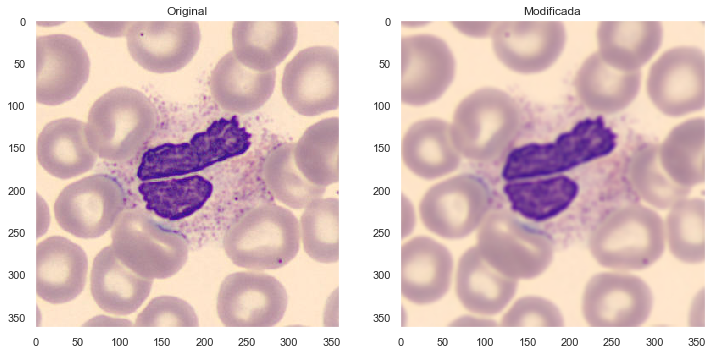

In [165]:
plot_2img(data[id],img_tf)

In [166]:
X_tf = img_to_matrix(img_tf)

## Graficas de como se ven los puntos

In [167]:
def scatter_3d(X,Y,Z,titulo):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(X,Y,Z,marker='o')
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")
    ax.set_title(titulo)
    plt.show()

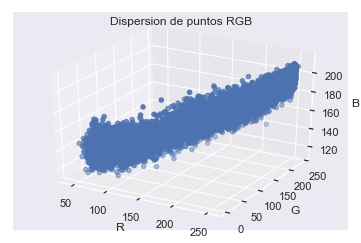

In [168]:
scatter_3d(X[:,0],X[:,1],X[:,2],"Dispersion de puntos RGB")

### Normalizamos los datos originales

In [169]:
X_norm = normalize(X,norm='l2')

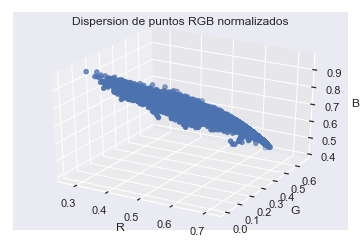

In [170]:
scatter_3d(X_norm[:,0],X_norm[:,1],X_norm[:,2],"Dispersion de puntos RGB normalizados")

### Escalamos los datos originales.
Se hace este procesimiento para que todos los puntos tengan norma menor a 1.

In [171]:
X_ns = scale(X_norm)

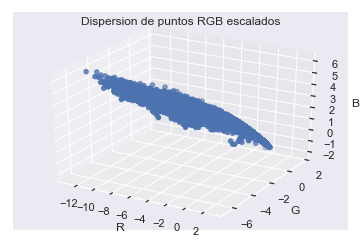

In [172]:
scatter_3d(X_ns[:,0],X_ns[:,1],X_ns[:,2],"Dispersion de puntos RGB escalados")

Vemos por un lado que la dispersión de los datos se reduce considerablemente si comparamos la gráfica de dispersión de los datos originales con las de los datos normalizados y los datos escalados. Por otro lado, podemos ver que no hay mucha diferencia de forma entre la gráfica de datos normalizados y los datos escalados. Teniendo en cuenta lo anterior, se transformará los datos de cada imagen normalizandolos, antes de continuar continuar con el resto del procedimiento.

## 2. Aplicar k-means

Como queremos segmentar una imagen de células en diferentes componentes a las cuales más adelante se pueda colocar un label, tal como: citoplasma, nucleo, etc, es necesario agrupar cada uno de los pixeles de la imagen a una de estas regiones.
Así que la técnica elegida para hacer la segmentación es *k-means*.


In [173]:
def iterate_K(X,max_groups):
    """
    Calcula la suma de errores cuadráticos (SSE) para un valores de k de 1 hasta max_groups
    
    args:
        X: matriz de datos
        max_groups: número máximo de grupos con el que se prueba
        
    returna:
        la lista de ks de 1 hasta max_groups, la lista de SSE para cada k y un diccionario con sus modelos asociados
    """
    sse = []
    models = {}
    for k in range(1,max_groups+1):
        models[k] = KMeans(init="random",n_clusters=k,random_state=42)
        models[k].fit(X)
        sse.append(models[k].inertia_)
    return sse, models

## 3. Determinar el mejor valor de k
El mejor valor k corresponde al número de regiones de la segmentación.


In [174]:
# Calculamos los SSE para cada grupo
# NOTA: la ejecucion de la funcion iterate_K se tarda entre 30 y 60 segundos por imagen porque hay muchos datos
max_gr = 7
ks = range(1,max_gr+1)
# Para la imagen original
sse_1_1, km_models_1_1 = iterate_K(X,max_gr)

In [175]:
# Para la imagen suavizada
sse_1_2, km_models_1_2 = iterate_K(X_tf,max_gr)

In [176]:
# Juntamos los SSE de cada una de las imagenes
sse = np.concatenate([[sse_1_1],[sse_1_2]]).T

Graficamos la evolución de el SSE en función de los valores k.

In [177]:
def elbow_plot(ks, sse,titulo):
    """
    Grafica el SSE contra el numero de clusters k
    """
    ax = sns.lineplot(x=ks,y=sse[:,0],label="original")
    ax = sns.lineplot(x=ks,y=sse[:,1],label="suavizada")
    ax.set(xlabel="k", ylabel="SSE",title=titulo)
    ax.legend()
    return ax

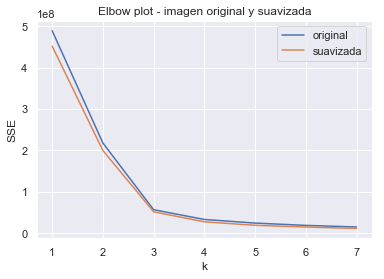

In [178]:
ax = elbow_plot(ks, sse,"Elbow plot - imagen original y suavizada")

De la gráfica anterior podemos ver que **el mejor k** con el cual se hace un mejor agrupamiento para la primera imagen es con k = 3.

## 4. Reconstruimos la imagen de las células
Primero, se reconstruye las imágenes segmentandolas a partir del mejor número de grupos seleccionado a partir de la gráfica elbow plot. Segundo, se compara los resultados entre la imágen original y la imagen suavizada para la primera imagen. Por último, a partir de esta comparación se aplica todo el proceso de nuevo pero con la mejor imagen que muestre resultados en la segmentación. 

In [179]:
def segment_img(X,modelos,original,k):
    """
    Segmenta una imagen con numero de grupos de k means elegido
    args:
        X: matriz de datos RGB de la imagen original
        modelos: diccionario de modelos de k-means 
        original: imagen original
        k: mejor  numero de grupos seleccionado
    returns:
        imagen segmentada
    """
    np.random.seed(15)
    row = 0
    img = np.copy(original)
    c = 255./k
    colores = np.random.randint(0,255,[4,3])
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            for n in range(k):
                if modelos[k].labels_[row] == n:
                    img[i,j,:] =  colores[n]#n*c*np.array([1,0,0]) #model.cluster_centers_[0]
                    break
            row = row + 1
    return img

        

In [180]:
# Segmentacion de imagenes
best_k = 3
img_seg1_1 = segment_img(X,km_models_1_1,data[id],best_k)
img_seg1_2 = segment_img(X_tf,km_models_1_2,img_tf,best_k)

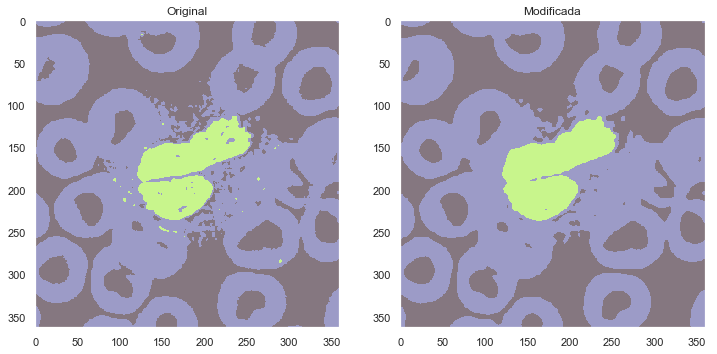

In [181]:
plot_2img(img_seg1_1,img_seg1_2)

Observe que la segmentación para la imágen suavizada es mejor que con la imagen original. En efecto, para la imagen original en regiones como el núcleo de la célula se marcan varios pixeles que son de otra region mientras que en la imagen suavizada este error de segmentación es mucho menor. Por lo tanto, se sugiere que para hacer la segmentación de imágenes de células se aplique un proceso de suavización antes de aplicar antes de cualquier otro procedimiento para mejorar la segmentación 

# Aplicación de metodología a todas las imagenes
Ahora aplicamos el todo el siguiente proceso al resto de las imágenes:
1. Suavización de las imagenes
2. Conversión de imagen a matriz de tamaño $mn \times 3$
3. Aplicar k-means y encontrar el mejor k para el agrupamiento
4. Segmentación de las imágenes

In [51]:
# ATENCION: ESTA CELDA TARDA UNOS 15 MINUTOS EN EJECUTARSE
X_suav = []
matrices = []
sse_mat = []
models = []
max_gr = 7
ks = range(1,max_gr+1)
print("Cantidad de imagenes: ",len(data))
for i in range(len(data)):
    print("------------------------------")
    print("Imagen ",i)
    X_suav.append(suavizar(data[i]))
    print("Imagen "+ str(i) + " suavizada")
    matrices.append(img_to_matrix(X_suav[i]))
    print("Conversion a matriz realizada")
    sse, km_models = iterate_K(matrices[i],max_gr)
    print("Modelos  k means encontrados")
    sse_mat.append(sse)
    models.append(km_models)

Cantidad de imagenes:  22
------------------------------
Imagen  0
Imagen 0 suavizada
Conversion a matriz realizada
Modelos  k means encontrados
------------------------------
Imagen  1
Imagen 1 suavizada
Conversion a matriz realizada
Modelos  k means encontrados
------------------------------
Imagen  2
Imagen 2 suavizada
Conversion a matriz realizada
Modelos  k means encontrados
------------------------------
Imagen  3
Imagen 3 suavizada
Conversion a matriz realizada
Modelos  k means encontrados
------------------------------
Imagen  4
Imagen 4 suavizada
Conversion a matriz realizada
Modelos  k means encontrados
------------------------------
Imagen  5
Imagen 5 suavizada
Conversion a matriz realizada
Modelos  k means encontrados
------------------------------
Imagen  6
Imagen 6 suavizada
Conversion a matriz realizada
Modelos  k means encontrados
------------------------------
Imagen  7
Imagen 7 suavizada
Conversion a matriz realizada
Modelos  k means encontrados
----------------------

In [182]:
sse_mat_copy = np.copy(sse_mat).T

## Graficas de elbow plots

Text(0,0.5,'SSE')

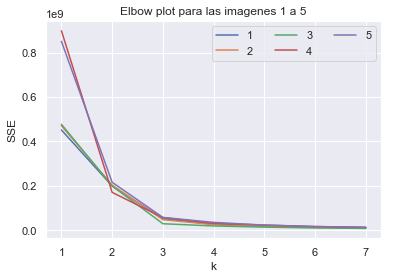

In [183]:
sse_plot = plt.plot(ks,sse_mat_copy[:,:5])
l =plt.legend([str(i) for i in range(1,6)],ncol=3)
plt.title("Elbow plot para las imagenes 1 a 5")
plt.xlabel("k")
plt.ylabel("SSE")

Vemos que el mejor k para las imagenes 1,2,3 y 5 es k = 3, Para la imagen 2 el mejor k es 2.

Text(0,0.5,'SSE')

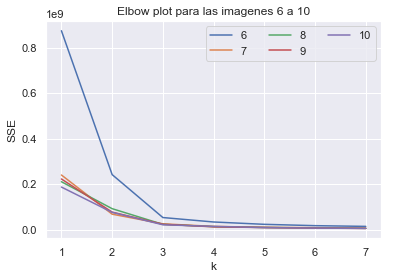

In [184]:
sse_plot = plt.plot(ks,sse_mat_copy[:,5:10])
l =plt.legend([str(i) for i in range(6,11)],ncol=3)
plt.title("Elbow plot para las imagenes 6 a 10")
plt.xlabel("k")
plt.ylabel("SSE")

Para las imagenes 6 a 10 el emjor k es con k = 3.

Text(0,0.5,'SSE')

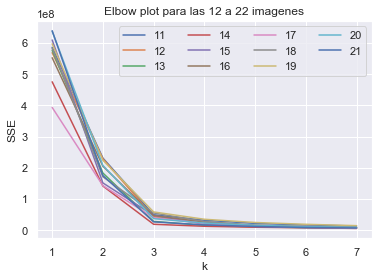

In [185]:
sse_plot = plt.plot(ks,sse_mat_copy[:,11:])
l =plt.legend([str(i) for i in range(11,22)],ncol=4)
plt.title("Elbow plot para las 12 a 22 imagenes")
plt.xlabel("k")
plt.ylabel("SSE")

## Graficas de centroides
Grafiquemos los centroides para ver si varía nentre imágenes

Vemos que para las imágenes 11 a 22 el punto de mayor inflexión en los elbow plots es para k = 3.

In [186]:
best_ks = [3,2]+20*[3]
#best_ks[18] = 4

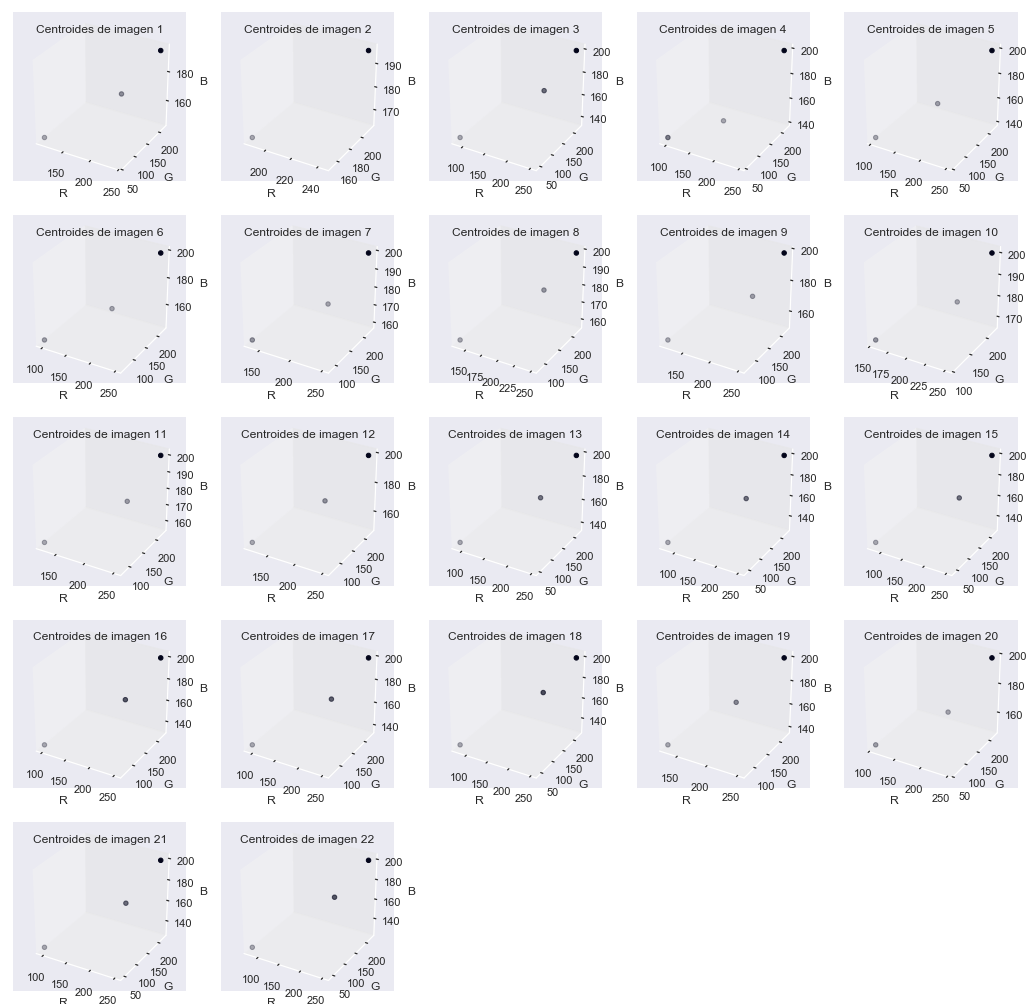

In [187]:
idx = 1
color = np.zeros(3)#np.array([0,1,2])
color2 = np.zeros(2)#np.array([0,1])
fig = plt.figure(figsize=(18,18))
for i in range(5):
    for j in range(5):
        if idx > 22:
            break
        X = models[idx-1][best_ks[idx-1]].cluster_centers_[:,0]
        Y = models[idx-1][best_ks[idx-1]].cluster_centers_[:,1]
        Z = models[idx-1][best_ks[idx-1]].cluster_centers_[:,2]
        ax = fig.add_subplot(5,5,idx,projection='3d')
        if idx == 2:
            ax.scatter(X,Y,Z,marker='o',c=color2)
        else:
            ax.scatter(X,Y,Z,marker='o',c=color)
        ax.set_title("Centroides de imagen "+str(idx))
        ax.set_title("Centroides de imagen "+str(idx))
        ax.set_xlabel("R")
        ax.set_ylabel("G")
        ax.set_zlabel("B")
        ax.grid(None)
        idx=idx+1        

In [154]:
# Segmentacion de todas las imagenes
imagenes_seg = []
for i in range(len(data)):
    imagenes_seg.append(segment_img(matrices[i],models[i],X_suav[i],best_ks[i]))

## Comparacion entre imagenes segmentadas e imagenes originales

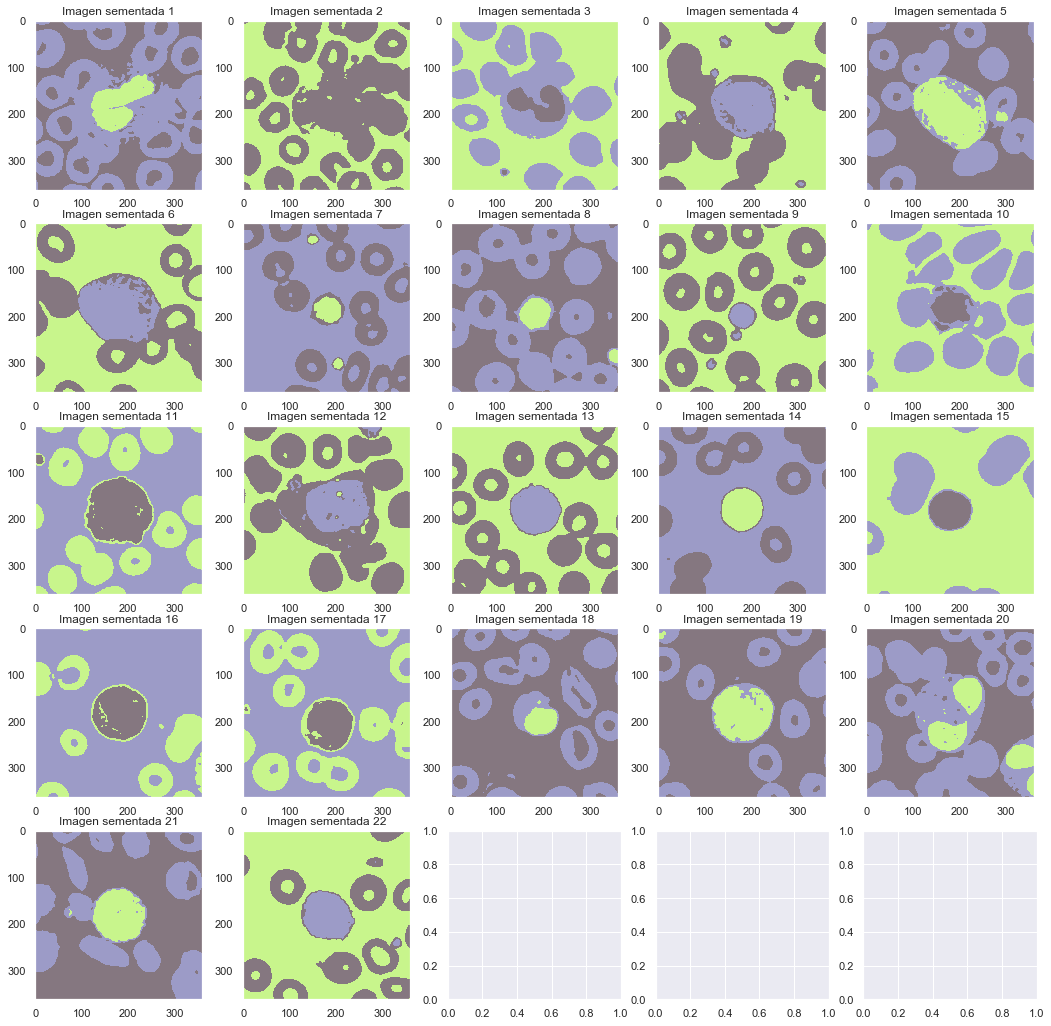

In [188]:
f,ax= plt.subplots(5,5,figsize=(18,18))
idx = 1
for i in range(5):
    for j in range(5):
        if idx > 22:
            break
        ax[i][j].imshow(imagenes_seg[idx-1])
        ax[i][j].set_title("Imagen sementada "+str(idx))
        ax[i][j].grid(None)
        idx=idx+1
        

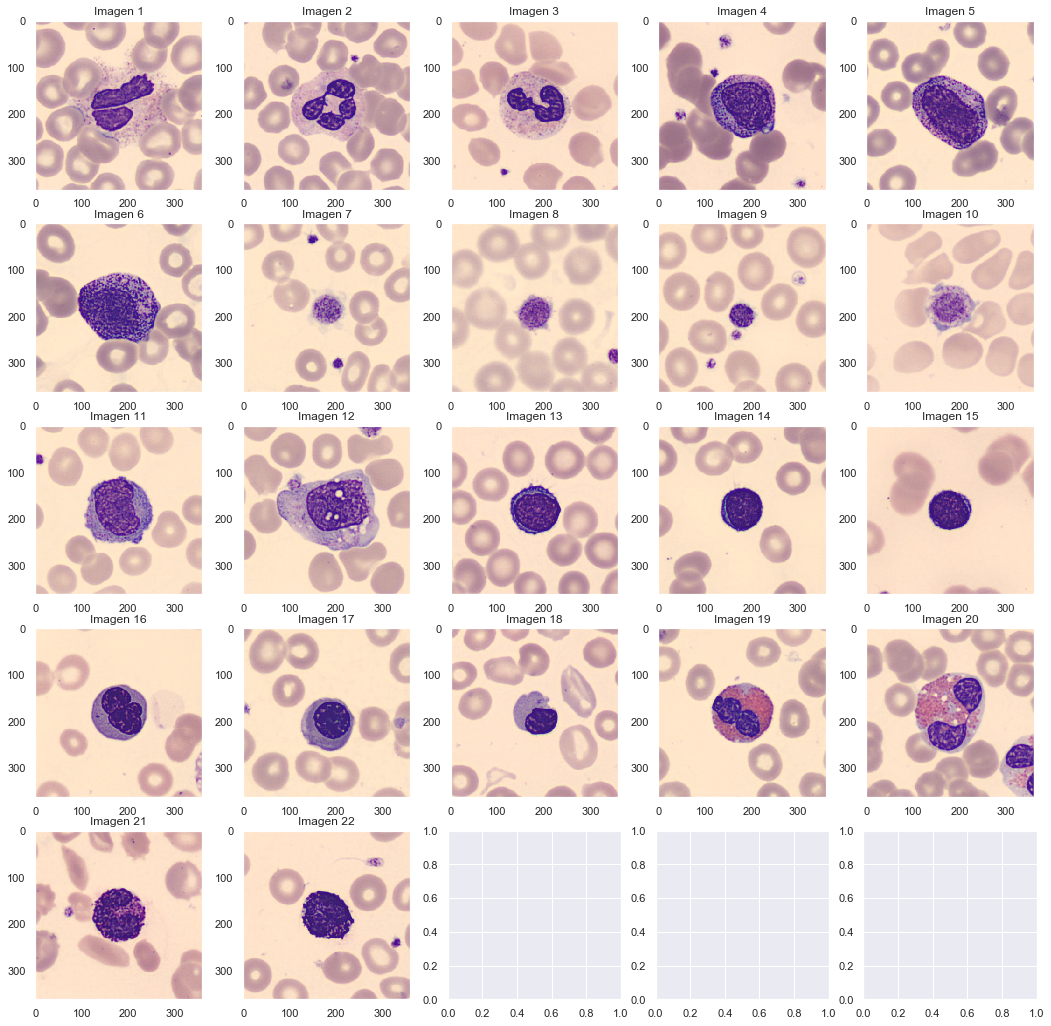

In [189]:
f,ax= plt.subplots(5,5,figsize=(18,18))
idx = 1
for i in range(5):
    for j in range(5):
        if idx > 22:
            break
        ax[i][j].imshow(data[idx-1])
        ax[i][j].set_title("Imagen "+str(idx))
        ax[i][j].grid(None)
        idx=idx+1

## Conclusiones y respuesta a preguntas
- **1. ¿Qué puede observar de los datos del problema?**
- Los datos del problema son imagenes de celulas que tienen distintas regiones de interés (citoplasma, nucleo, fondo de imagen, etc). Se puede observar que la mayoría de las células tienen 3 regiones importantes (nucleo, citoplasma y fondo de imagen) a excepción  de las imagenes 19 y 20 que muestran un contenido distinto (anormal) en el citoplasma.
- **2. ¿Se tuvo que realizar algun tipo de transformación a los datos?, ¿Porqué?**
Se tuvo que aplicar 2 transformaciones a las imagenes:
    1. Se transformó cada imagen de dimension $m\times n$ a una matriz de datos de dimensión $mn \times 3$. Cada una de las columnas de esta matriz tiene el valor de intensidad de rojo, azul y verde para cada uno de los pixeles de la imagen.  
    2. Se normalizaron los datos de la matriz asociada a cada imagen.
- **3. ¿Qué mejoras tuvo que hacer en el algoritmo de salida?, ¿Porqué tuvó que hacer estas mejoras?**
- Se aplicó un filtro de suavizacion a las imagenes ya que hay regiones de interés cuya textura es muy rugosay por ende, al segmentar la imagen, aparecen pixeles de un color que no corresponde a la región de donde se encuentra el pixel. Al aplicar la suavización, se minimizan estas irregularidades dentro de cada región segmentada. 
- **4. ¿Cómo escogio el valor de  K ?**
- El valor de k se eligió al graficar el Elbow plot para cada imagen. En esta gráfica, la variable independiente es el número de clusters *k* y la dependiente es la suma de los errores cuadrados (SSE) que representa la suma de las distancias cuadradas de cada uno de los puntos al centroide de más cercano de los grupos. 
- **5.¿Son los centrodides de los clusters similares para todas las imagenes? ¿Si, no, porqué?**
- Observamos que los centroides no son similares para todas las imagenes ya que el centroide del medio de las imagenes 19 y 20 no está tan cerca a los clusters del medio de las otras imagenes. Se cree que esto ocurre ya queen las imagenes 19 y 20 hay una region dentro del citoplasma que es anormal comparado al resto de celulas de las otras imagenes.
- **6. ¿Qué puede concluir al final de este proyecto?, escriba su opinión frente a los metodos de clustering y como se aplicó en este proyecto.**
- Se puede concluir que para segmentar una imagen el método de *k-means* es muy efectivo aunque su tiempo de ejecución no es muy bueno si se tienen imágenes con demasiados pixeles. Sin embargo, hay que evaluar por qué hay casos en los que no se segmenta la imagen como es esperado, como lo vimos en este caso. Se cree que una forma de mejorar la segmentación es estimar el parámetro k aplicando validación cruzada.